In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [93]:
sns.set()
%matplotlib inline

In [94]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
%autoreload 2

In [96]:
from sir_models.sir import SIROneStain

# Load data

In [97]:
df = pd.read_csv('data/data.csv', sep=';')

In [98]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [99]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [100]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


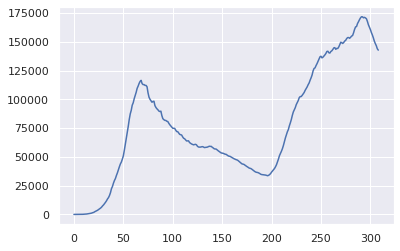

In [101]:
df['infected'].plot()

In [102]:
df_smoothed = df.drop(columns=['region']).rolling(3).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13
2,122.000000,27.333333,0.000000,0.0,0.0,11.666667,0.000000,27.333333,2020-03-14
3,204.000000,32.000000,0.333333,0.0,0.0,4.666667,0.333333,31.666667,2020-03-15
4,286.000000,41.000000,0.666667,0.0,0.0,9.000000,0.333333,40.333333,2020-03-16
5,368.000000,47.666667,1.000000,0.0,0.0,6.666667,0.333333,46.666667,2020-03-17
6,450.666667,64.666667,1.000000,0.0,0.0,17.000000,0.000000,63.666667,2020-03-18
7,534.333333,79.666667,1.000000,0.0,0.0,15.000000,0.000000,78.666667,2020-03-19
8,619.000000,105.000000,2.333333,0.0,0.0,25.333333,1.333333,102.666667,2020-03-20
9,704.000000,122.000000,4.666667,0.0,0.0,17.000000,2.333333,117.333333,2020-03-21


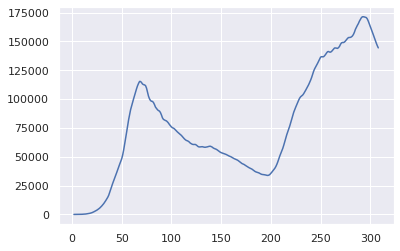

In [103]:
df_smoothed.infected.plot()

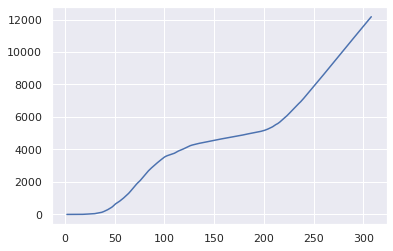

In [104]:
df_smoothed.total_dead.plot()

In [105]:
df = df_smoothed.dropna().reset_index(drop=True)

In [106]:
# r0 = beta / gamma
# r0 ~ 3

# rt ~ 1.05

# Set global params

In [107]:
population = 12_000_000
#population = 140_000_000

In [108]:
start_day = df.iloc[0].date
end_day = df.iloc[-1].date
days_in_cycle = 1
dates = pd.date_range(start=start_day,
                      end=end_day,
                      freq=f"{days_in_cycle}D")

t = np.arange(len(dates))
len(t)

307

# SIR first peak

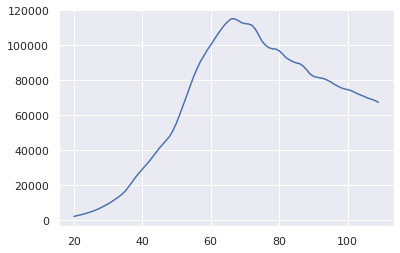

In [109]:
df[20:110]['infected'].plot()

In [110]:
df[20:110]['infected']

20      2266.666667
21      2729.000000
22      3179.000000
23      3683.666667
24      4281.000000
           ...     
105    70748.000000
106    69851.333333
107    69275.000000
108    68544.333333
109    67526.666667
Name: infected, Length: 90, dtype: float64

In [111]:
model = SIROneStain(population)

subset = df[20:110]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [112]:
R0 = result.params['beta']/result.params['gamma']
R0

1.8605797115874834

In [113]:
S, I, R, D = model.predict_train()

In [114]:
R[0], I[0], D[0]

(0.0, 147583.99503554, 0.0)

In [115]:
R[20]

601807.8797351826

In [116]:
I[:20].cumsum()[-1]

6400973.725970491

In [117]:
I[:20].cumsum()[-1]/R[20]

10.636241135272526

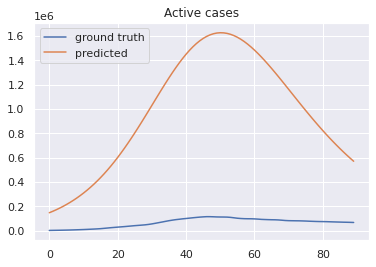

In [118]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

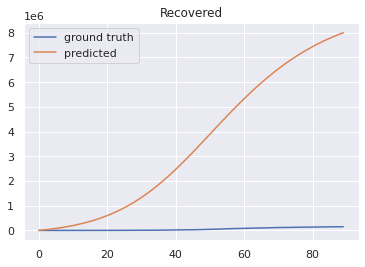

In [119]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

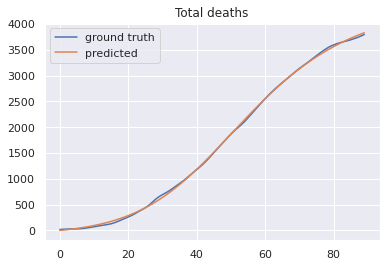

In [120]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

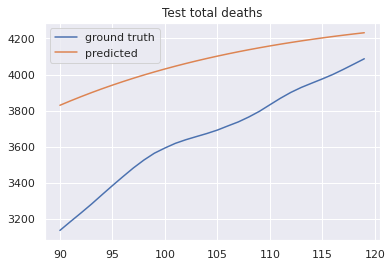

In [121]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

# SIR recent

In [122]:
model = SIROneStain(population)

subset = df[150:]
model.fit(subset)

S, I, R, D = model.predict_train()
result = model.fit_result_
result

In [123]:
R0 = result.params['beta']/result.params['gamma']
R0

0.8377623228853992

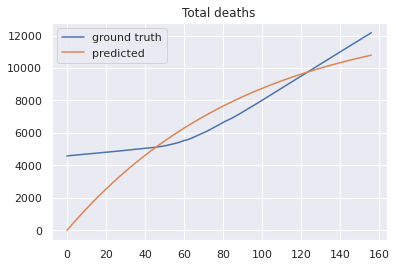

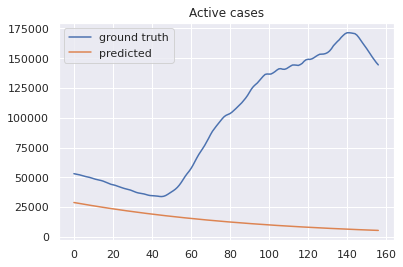

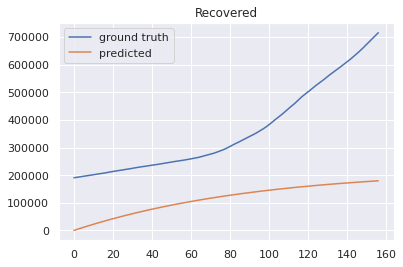

In [124]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

# SIR full

In [125]:
model = SIROneStain(population)
subset = df
model.fit(subset)

S, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

1.0623615334393566

In [126]:
result

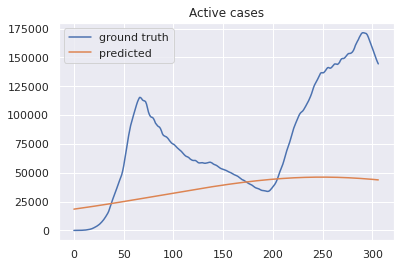

In [127]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

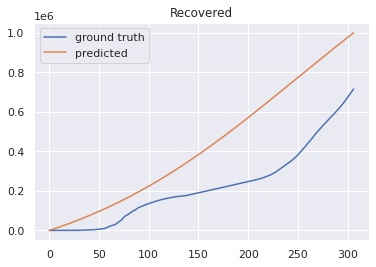

In [128]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

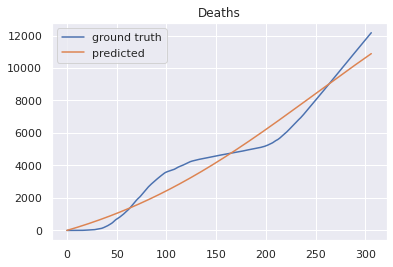

In [129]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Deaths')
plt.show()

# Evaluate predictive ability

In [146]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In [149]:
tscv = TimeSeriesSplit(max_train_size=100, n_splits=10)

Fold 0
37 27


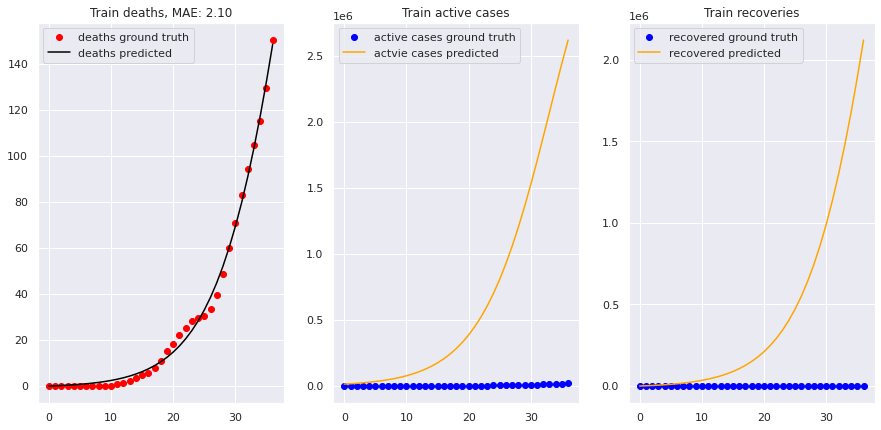

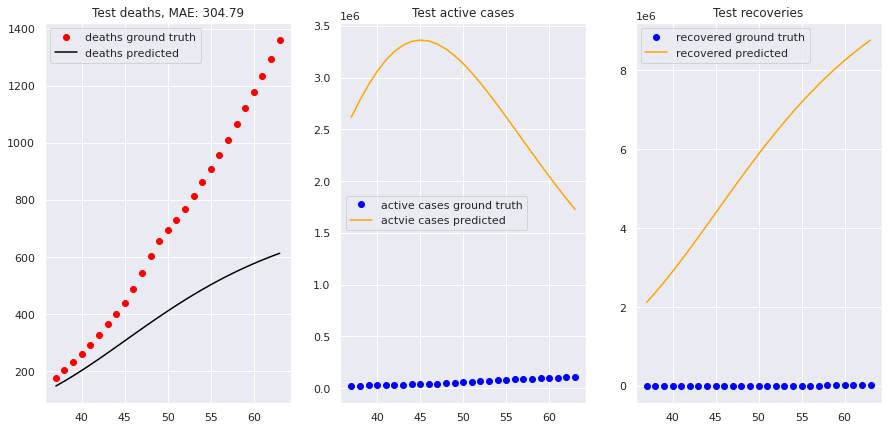

Test R^2: -0.08702337833710572
Fold 1
64 27


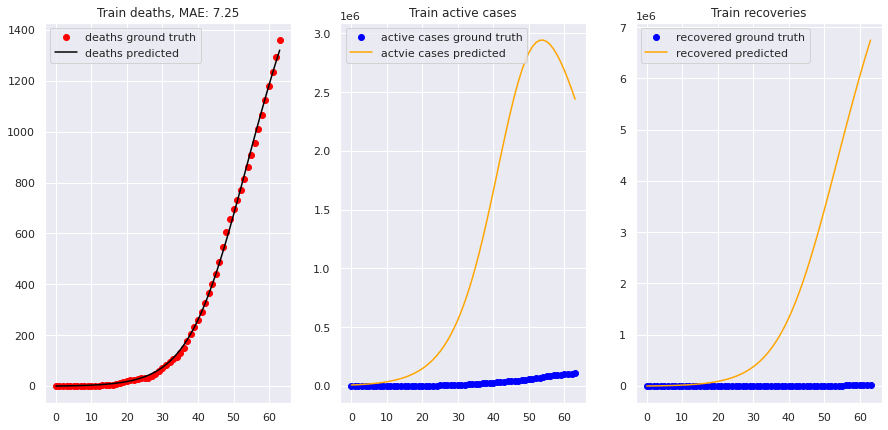

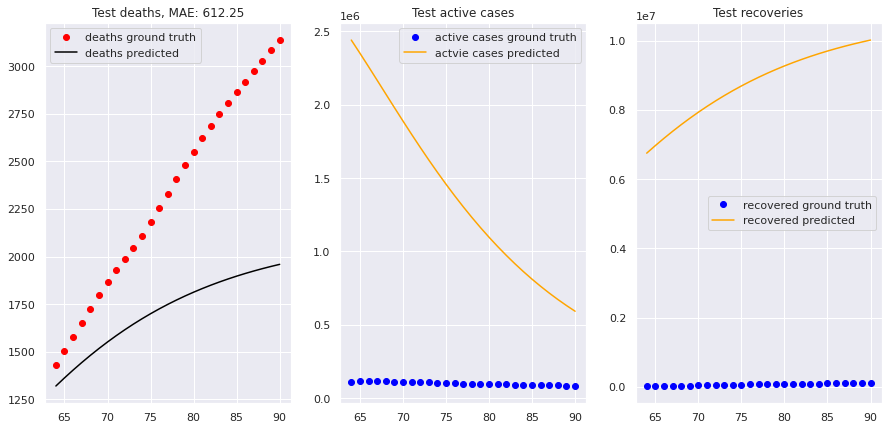

Test R^2: -0.803627318696849
Fold 2
91 27


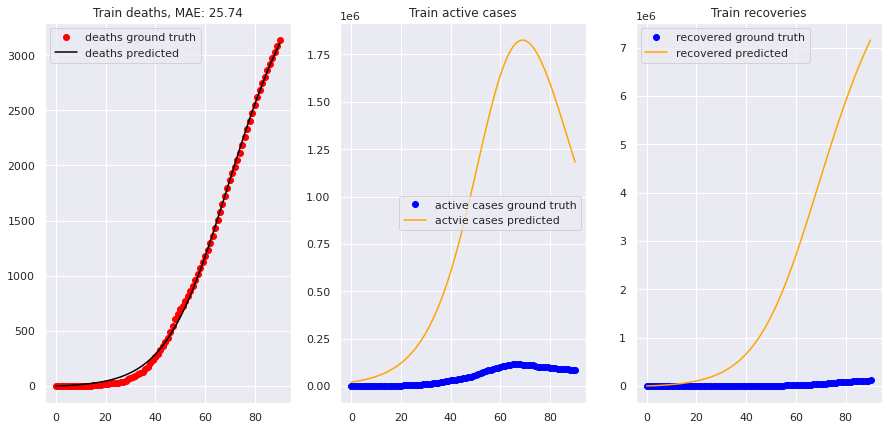

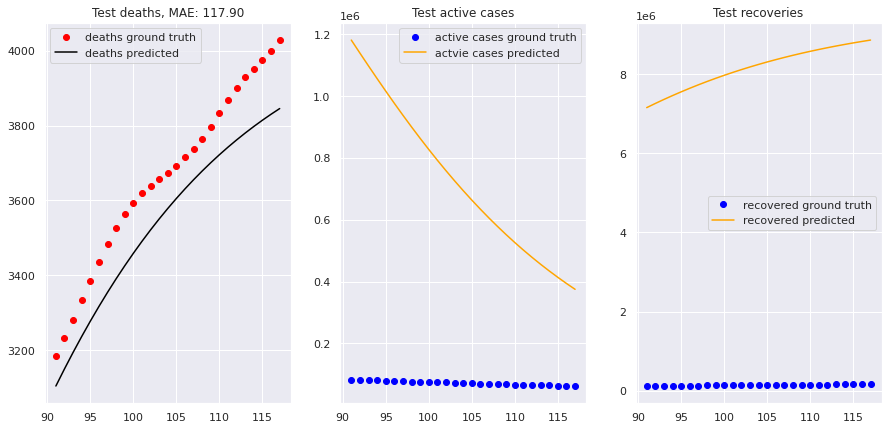

Test R^2: 0.7397324903271727
Fold 3
100 27


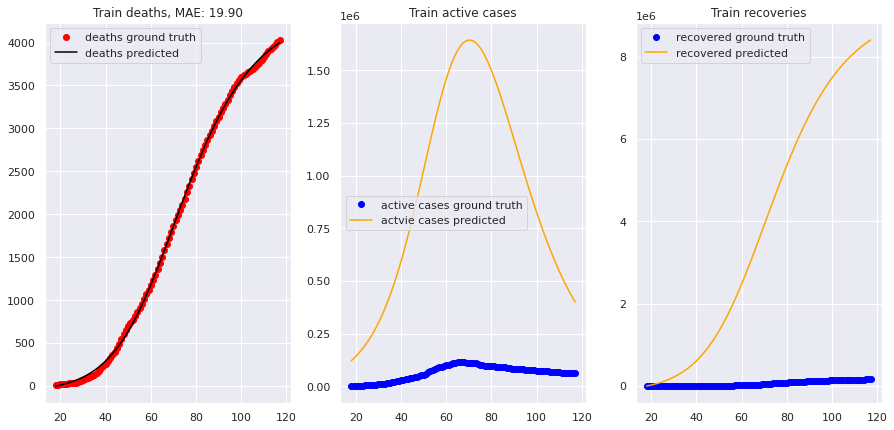

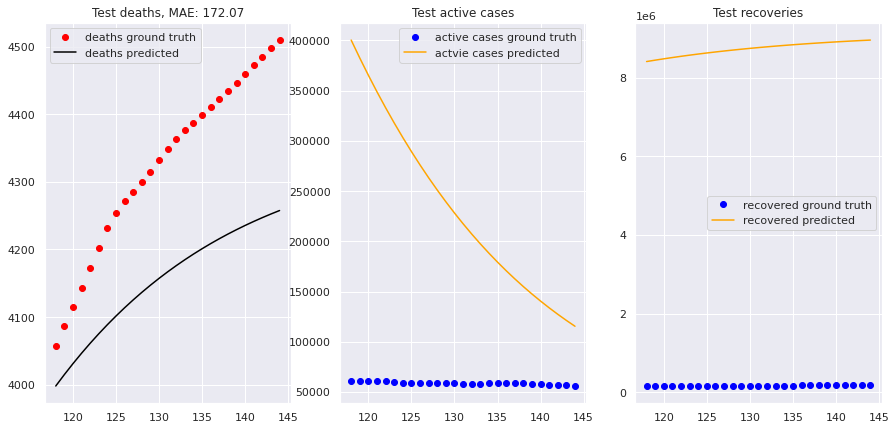

Test R^2: -0.9419961255260212
Fold 4
100 27


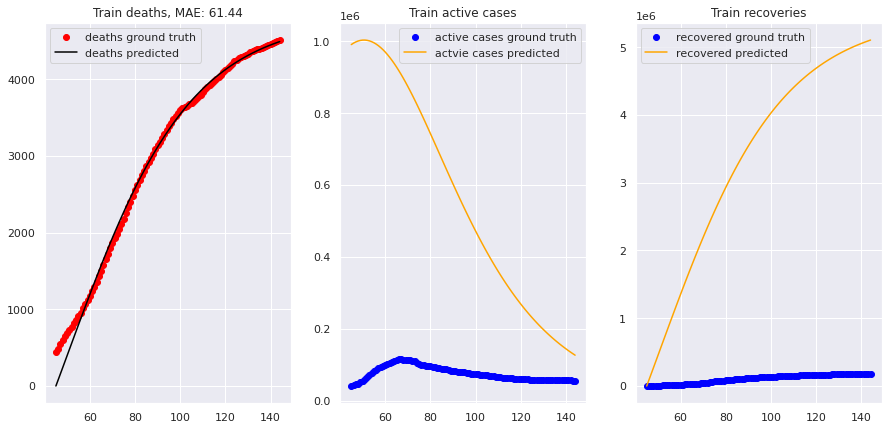

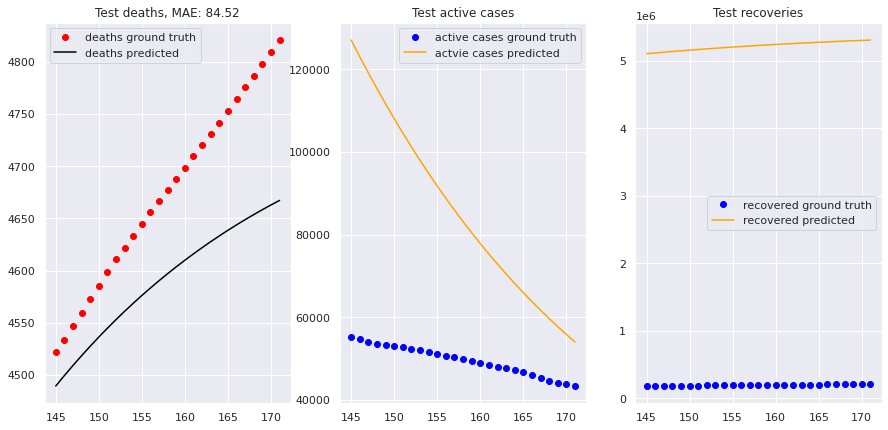

Test R^2: -0.08161719786472488
Fold 5
100 27


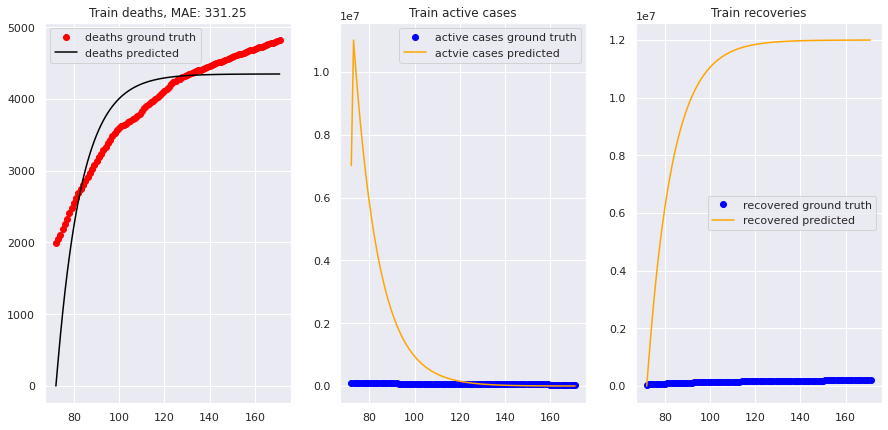

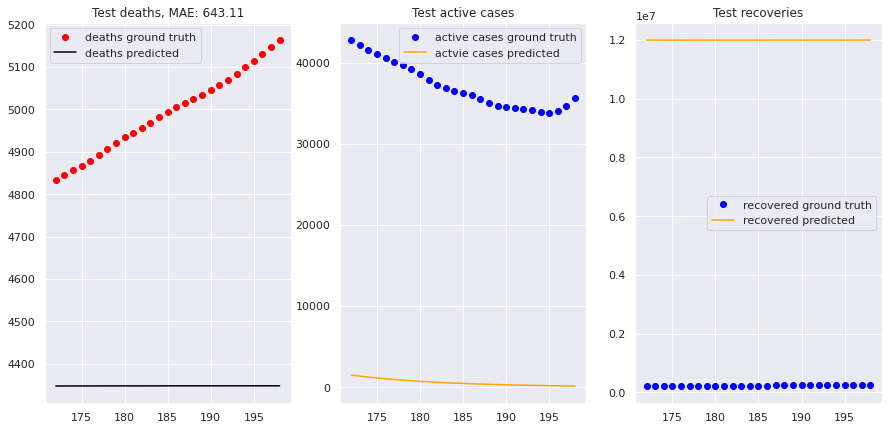

Test R^2: -44.94588766436306
Fold 6
100 27


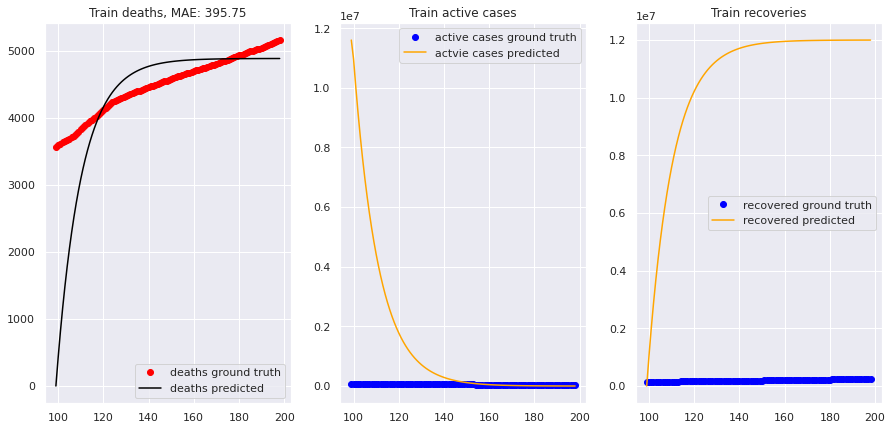

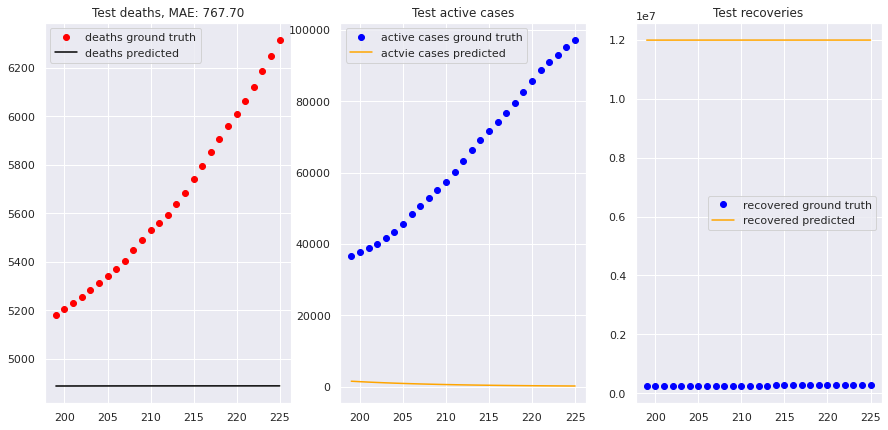

Test R^2: -5.033256960570606
Fold 7
100 27


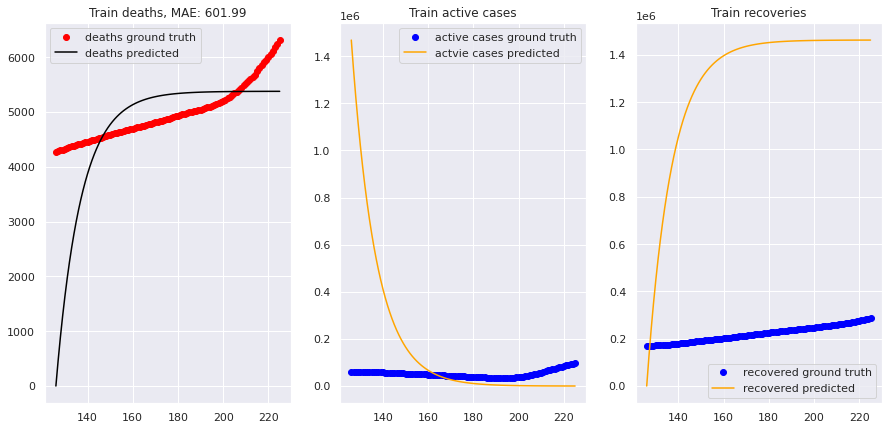

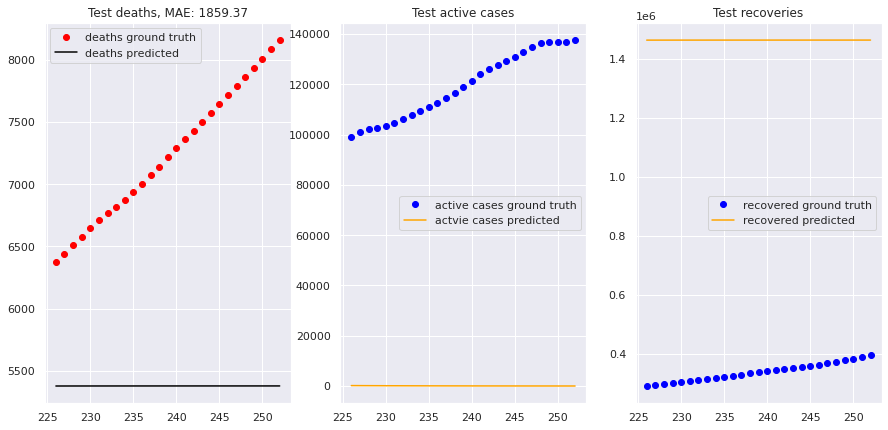

Test R^2: -12.218531851970658
Fold 8
100 27


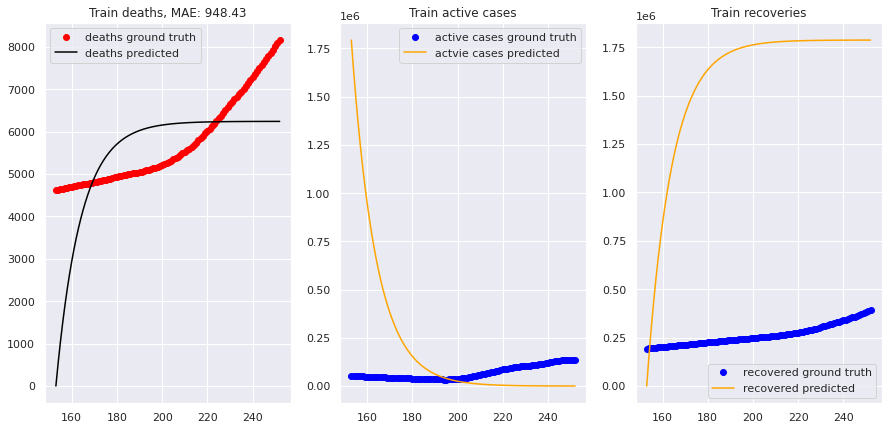

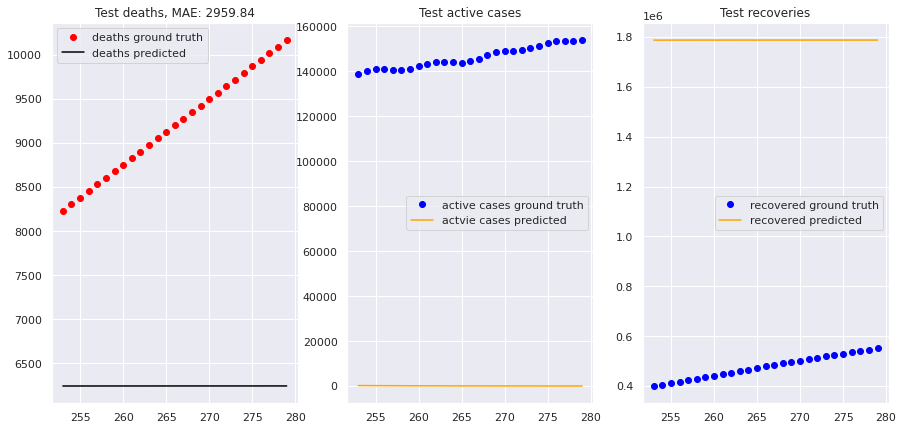

Test R^2: -26.021682557800943
Fold 9
100 27


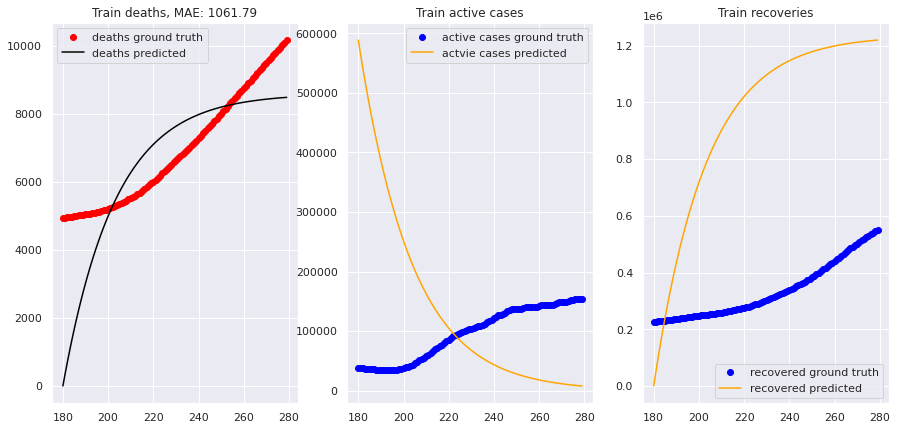

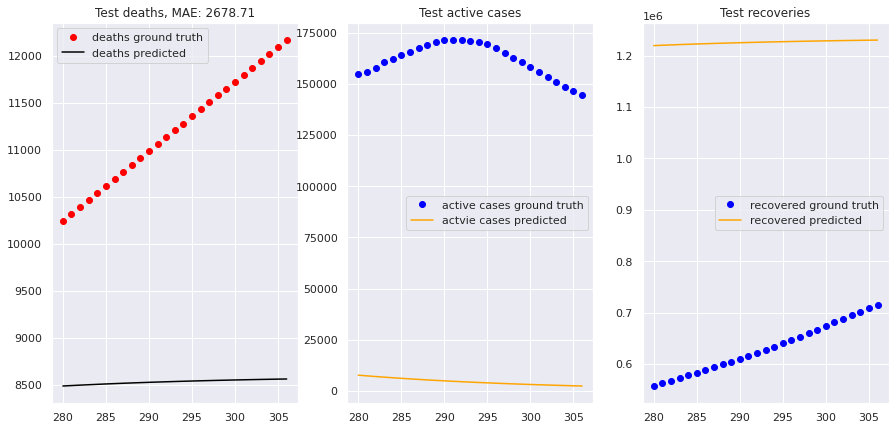

Test R^2: -21.45669752359157


In [150]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset)

    result = model.fit_result_
    params.append(result.params)
    #result.plot_fit(datafmt="-")
    
    train_S, train_I, train_R, train_D = model.predict_train()
    S, I, R, D = model.predict_test(test_index)
    
    train_mae = mean_absolute_error(train_subset['total_dead'], train_D)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(train_index, train_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(train_index, train_D, label='deaths predicted', color='black')
    plt.title(f'Train deaths, MAE: {train_mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_index, train_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(train_index, train_I, label='actvie cases predicted', color='orange')
    plt.title(f'Train active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_index, train_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(train_index, train_R, label='recovered predicted', color='orange')
    plt.title(f'Train recoveries')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(test_subset['total_dead'], D)
    maes.append(mae)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(test_index, test_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(test_index, D, label='deaths predicted', color='black')
    plt.title(f'Test deaths, MAE: {mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(test_index, test_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(test_index, I, label='actvie cases predicted', color='orange')
    plt.title(f'Test active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(test_index, test_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(test_index, R, label='recovered predicted', color='orange')
    plt.title(f'Test recoveries')
    plt.legend()
    plt.show()
    
    print('Test R^2:', r2_score(test_subset['total_dead'], D))

In [133]:
params[-1]

name,value,standard error,relative error,initial value,min,max,vary
population,12000000.0,0.00000000,(0.00%),12000000,-inf,inf,False
beta,0.09286200,4.1430e-04,(0.45%),1.2,0.00000000,10.0000000,True
gamma,0.09090909,0.00000000,(0.00%),0.09090909090909091,0.00000000,1.00000000,False
alpha,0.03507451,0.00321735,(9.17%),0.018,0.00000000,0.20000000,True
rho,0.04545455,0.00000000,(0.00%),0.045454545454545456,0.00000000,0.08333333,False
i0,14551.7313,567.317855,(3.90%),1000,0.00000000,12000000.0,True


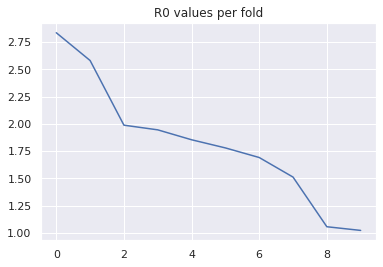

In [134]:
betas = [p['beta'] for p in params]
gamma = params[0]['gamma']
r0s = [b/gamma for b in betas]
r0s

plt.plot(r0s)
plt.title('R0 values per fold')
plt.show()

In [135]:
r0s[-1]

1.0214820120528816

In [136]:
np.mean(maes)

831.891611393866

In [137]:
R[-1]

543824.3584265392

In [138]:
I.cumsum()[-1] - R[-1] - D[-1]

53667.67558407107

280    722018.666667
281    728905.000000
282    736078.000000
283    743510.333333
284    750405.666667
285    757436.333333
286    764493.000000
287    772159.000000
288    779297.333333
289    786081.666667
290    792253.000000
291    797919.333333
292    803690.000000
293    809549.333333
294    815524.333333
295    820594.333333
296    824892.333333
297    828987.000000
298    833512.000000
299    838463.666667
300    843477.000000
301    848409.666667
302    853124.000000
303    857711.333333
304    862332.333333
305    866988.000000
306    872059.333333
Name: total_infected, dtype: float64

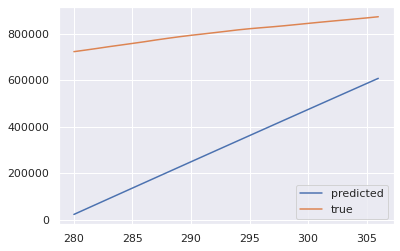

In [145]:
plt.plot(test_index, I.cumsum(), label='predicted')
plt.plot(test_index, test_subset.total_infected, label='true')
plt.legend()